# Robustness Analysis: Multiple Learners for Nuisance Models

This notebook implements robustness verification using 10 different machine learning algorithms:
- **For Outcome Model (Y):** Predict SomeRiskHome and VeryHighRiskHome
- **For Treatment/Propensity Model (T):** Predict water_treatment

Models tested:
1. OLS (benchmark)
2. Logistic Regression
3. Lasso
4. Ridge
5. ElasticNet
6. Naive Bayes
7. Random Forest
8. XGBoost
9. LightGBM
10. AdaBoost

**Note:** Models 1-6 use scaled features, models 7-10 use unscaled features (tree-based)

In [1]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Prepare Data

In [2]:
# Load cleaned data
data = pd.read_csv('mics_clean.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nMissing values:\n{data.isnull().sum()[data.isnull().sum() > 0]}")

# Drop rows with NaN values
data_complete = data.dropna()
print(f"\nComplete cases: {data_complete.shape}")

# Display basic info
data_complete.head()

Dataset shape: (56721, 54)

Missing values:
PipedWater                     3
WellandSpringWater             3
RainandSurfaceWater            3
PurchasedWater                 3
Basic_water_service            2
Limited_water_service          2
Unimproved_water_service       3
Open_defecation             1209
dtype: int64

Complete cases: (55510, 54)


,SomeRiskHome,VeryHighRiskHome,water_treatment,Any_U5,Girls_less_than15,Boys_15or_less,ImprovedWaterSource,PipedWater,WellandSpringWater,RainandSurfaceWater,...,country_cat_Togo,country_cat_Trinidad and Tobago,country_cat_Viet Nam,country_cat_Zimbabwe,WS1_g_Packaged/Bottled water,WS1_g_Piped water,WS1_g_Protected well/spring,WS1_g_Surface/Rain water,WS1_g_Tube/Well/Borehole,WS1_g_Unprotected well/spring
0,1,0,0,1,0,1,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,1,0,0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,0,1,0,0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,0,1,0,1,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,0,0,0,0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 2. Prepare Features and Targets

In [3]:
# Define outcomes and treatment
outcome_vars = ['SomeRiskHome', 'VeryHighRiskHome']
treatment_var = 'water_treatment'

# Covariates (all variables except outcomes and treatment)
covariates = [col for col in data_complete.columns 
              if col not in outcome_vars + [treatment_var]]

print(f"Number of covariates: {len(covariates)}")
print(f"Covariates: {covariates[:10]}...")

# Prepare feature matrix
X = data_complete[covariates]

# Prepare scaled version for non-tree models
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Scaled feature matrix shape: {X_scaled.shape}")

Number of covariates: 51
Covariates: ['Any_U5', 'Girls_less_than15', 'Boys_15or_less', 'ImprovedWaterSource', 'PipedWater', 'WellandSpringWater', 'RainandSurfaceWater', 'PurchasedWater', 'Basic_water_service', 'Limited_water_service']...

Feature matrix shape: (55510, 51)
Scaled feature matrix shape: (55510, 51)


## 3. Model Definitions and Hyperparameter Spaces

In [4]:
def get_models_and_params():
    """
    Define all models and their hyperparameter spaces.
    Returns models that need scaling and those that don't.
    """
    
    # Models that need scaled features
    models_scaled = {
        'OLS': {
            'model': LinearRegression(),
            'params': {},  # No hyperparameters to tune
            'is_classifier': False
        },
        'Logistic': {
            'model': LogisticRegression(max_iter=1000, random_state=42),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            },
            'is_classifier': True
        },
        'Lasso': {
            'model': Lasso(max_iter=1000, random_state=42),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
            },
            'is_classifier': False
        },
        'Ridge': {
            'model': Ridge(max_iter=1000, random_state=42),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            },
            'is_classifier': False
        },
        'ElasticNet': {
            'model': ElasticNet(max_iter=1000, random_state=42),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
            },
            'is_classifier': False
        },
        'NaiveBayes': {
            'model': GaussianNB(),
            'params': {
                'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
            },
            'is_classifier': True
        }
    }
    
    # Models that don't need scaled features (tree-based)
    models_unscaled = {
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'is_classifier': True
        },
        'XGBoost': {
            'model': XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 4, 5, 6],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            },
            'is_classifier': True
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 4, 5],
                'learning_rate': [0.01, 0.05, 0.1],
                'num_leaves': [15, 31, 63],
                'subsample': [0.6, 0.8, 1.0]
            },
            'is_classifier': True
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.5, 1.0]
            },
            'is_classifier': True
        }
    }
    
    return models_scaled, models_unscaled

## 4. Helper Functions

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_classifier(y_true, y_pred, y_pred_proba=None):
    """
    Calculate binary classification metrics.
    """
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    if y_pred_proba is not None:
        try:
            metrics['AUC'] = roc_auc_score(y_true, y_pred_proba)
        except:
            metrics['AUC'] = np.nan
    else:
        metrics['AUC'] = np.nan
    
    return metrics


def train_and_evaluate_model(model_name, model_config, X_train, y_train, X_test, y_test, use_scaled=True):
    """
    Train a model with hyperparameter tuning and evaluate on both train and test sets.
    """
    print(f"\nTraining {model_name}...")
    
    model = model_config['model']
    params = model_config['params']
    is_classifier = model_config['is_classifier']
    
    # Hyperparameter tuning if params exist
    if params:
        random_search = RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=10,
            cv=3,
            scoring='roc_auc' if is_classifier else 'neg_mean_squared_error',
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        print(f"  Best params: {random_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)
    
    # Make predictions on TRAINING set
    if is_classifier:
        y_train_pred = best_model.predict(X_train)
        y_train_proba = best_model.predict_proba(X_train)[:, 1] if hasattr(best_model, 'predict_proba') else None
    else:
        y_train_continuous = best_model.predict(X_train)
        y_train_pred = (y_train_continuous > 0.5).astype(int)
        y_train_proba = y_train_continuous
    
    train_metrics = evaluate_classifier(y_train, y_train_pred, y_train_proba)
    
    # Make predictions on TEST set
    if is_classifier:
        y_test_pred = best_model.predict(X_test)
        y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
    else:
        y_test_continuous = best_model.predict(X_test)
        y_test_pred = (y_test_continuous > 0.5).astype(int)
        y_test_proba = y_test_continuous
    
    test_metrics = evaluate_classifier(y_test, y_test_pred, y_test_proba)
    
    return best_model, train_metrics, test_metrics


def get_model_scores(model, X):
    """
    Helper to get probability scores or decision function values
    depending on the model type.
    """
    if hasattr(model, 'predict_proba'):
        try:
            return model.predict_proba(X)[:, 1]
        except Exception:
            pass
    if hasattr(model, 'decision_function'):
        return model.decision_function(X)
    return model.predict(X)

def plot_roc_for_target(title, results_dict, y_true, X_test_scaled, X_test_unscaled):
    """
    Plot ROC curves for all models for a single target.
    """
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    for model_name, data in results_dict.items():
        if 'model' not in data:
            print(f'Model object not found for {model_name} in {title}. Skipping.')
            continue
        model = data['model']
        use_scaled = data.get('use_scaled', False)
        X_eval = X_test_scaled if use_scaled else X_test_unscaled
        y_scores = get_model_scores(model, X_eval)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve: {title}')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_comparison_table(results_dict, title):
    """
    Create a formatted comparison table with both train and test metrics.
    """
    rows = []
    for model_name, metrics in results_dict.items():
        train_m = metrics['train']
        test_m = metrics['test']
        rows.append({
            'Model': model_name,
            'Train_Acc': f"{train_m['Accuracy']:.4f}",
            'Test_Acc': f"{test_m['Accuracy']:.4f}",
            'Train_F1': f"{train_m['F1']:.4f}",
            'Test_F1': f"{test_m['F1']:.4f}",
            'Train_AUC': f"{train_m['AUC']:.4f}" if not np.isnan(train_m['AUC']) else 'N/A',
            'Test_AUC': f"{test_m['AUC']:.4f}" if not np.isnan(test_m['AUC']) else 'N/A'
        })
    
    df = pd.DataFrame(rows)
    # Sort by Test F1 score
    df_sorted = df.sort_values(by='Test_F1', ascending=False).reset_index(drop=True)
    
    print(f"\n{'='*120}")
    print(f"{title.center(120)}")
    print(f"{'='*120}")
    print(df_sorted.to_string(index=False))
    print(f"{'='*120}\n")
    
    return df_sorted

## 5. Outcome Model Analysis: SomeRiskHome

### Predicting SomeRiskHome with 10 different models

Train/Test split for SomeRiskHome:
  Training: 44408 samples
  Test: 11102 samples
  Class distribution (train): {1: np.int64(33316), 0: np.int64(11092)}

Target variable: SomeRiskHome
Class distribution:
SomeRiskHome
1    41645
0    13865
Name: count, dtype: int64

Training models with SCALED features

Training OLS...

Training Logistic...
  Best params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

Training Lasso...
  Best params: {'alpha': 0.0001}

Training Ridge...
  Best params: {'alpha': 100}

Training ElasticNet...
  Best params: {'l1_ratio': 0.1, 'alpha': 0.001}

Training NaiveBayes...
  Best params: {'var_smoothing': 1e-06}

Training models with UNSCALED features (tree-based)

Training RandomForest...
  Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}

Training XGBoost...
  Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Training LightGBM...
  Best par

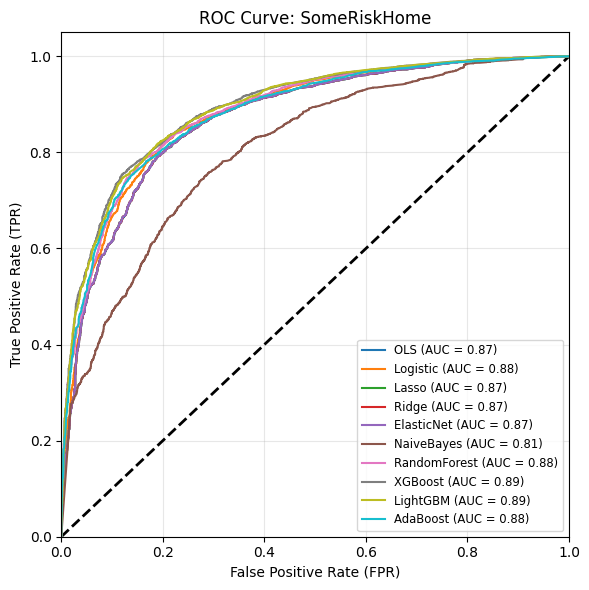

In [6]:
# Target: SomeRiskHome
y_somerisk = data_complete['SomeRiskHome']

# Split data into train/test (80/20) with matching indices
X_train, X_test, y_somerisk_train, y_somerisk_test = train_test_split(
    X, y_somerisk, test_size=0.2, random_state=42, stratify=y_somerisk
)

# Scale the split data
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# Preserve test splits for ROC plotting
X_test_somerisk = X_test
X_test_somerisk_scaled = X_test_scaled

print(f'Train/Test split for SomeRiskHome:')
print(f'  Training: {len(y_somerisk_train)} samples')
print(f'  Test: {len(y_somerisk_test)} samples')
print(f'  Class distribution (train): {dict(y_somerisk_train.value_counts())}')

print(f"\nTarget variable: SomeRiskHome")
print(f"Class distribution:\n{y_somerisk.value_counts()}")

# Get model configurations
models_scaled, models_unscaled = get_models_and_params()

# Train models that need scaling
results_somerisk = {}

print("\n" + "="*60)
print("Training models with SCALED features")
print("="*60)

for model_name, model_config in models_scaled.items():
    model, train_metrics, test_metrics = train_and_evaluate_model(model_name, model_config, X_train_scaled, y_somerisk_train, X_test_scaled, y_somerisk_test, use_scaled=True)
    results_somerisk[model_name] = {'model': model, 'train': train_metrics, 'test': test_metrics, 'use_scaled': True}

print("\n" + "="*60)
print("Training models with UNSCALED features (tree-based)")
print("="*60)

# Train tree-based models without scaling
for model_name, model_config in models_unscaled.items():
    model, train_metrics, test_metrics = train_and_evaluate_model(model_name, model_config, X_train, y_somerisk_train, X_test, y_somerisk_test, use_scaled=False)
    results_somerisk[model_name] = {'model': model, 'train': train_metrics, 'test': test_metrics, 'use_scaled': False}

# Create comparison table
table_somerisk = create_comparison_table(results_somerisk, "SomeRiskHome - Outcome Model Comparison")

# ROC curve with all models for this target
plot_roc_for_target("SomeRiskHome", results_somerisk, y_somerisk_test, X_test_somerisk_scaled, X_test_somerisk)

In [7]:
# Export to LaTeX
latex_somerisk = table_somerisk.to_latex(
    index=False,
    caption="SomeRiskHome - Robustness Analysis: 10 ML Models",
    label="tab:robustness_somerisk"
)

with open('tables/somerisk_robustness_table.tex', 'w') as f:
    f.write(latex_somerisk)

## 6. Outcome Model Analysis: VeryHighRiskHome

### Predicting VeryHighRiskHome with 10 different models

Train/Test split for VeryHighRiskHome:
  Training: 44408 samples
  Test: 11102 samples
  Class distribution (train): {0: np.int64(30446), 1: np.int64(13962)}
Target variable: VeryHighRiskHome
Class distribution:
VeryHighRiskHome
0    38057
1    17453
Name: count, dtype: int64

Training models with SCALED features

Training OLS...

Training Logistic...
  Best params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 100}

Training Lasso...
  Best params: {'alpha': 0.0001}

Training Ridge...
  Best params: {'alpha': 100}

Training ElasticNet...
  Best params: {'l1_ratio': 0.1, 'alpha': 0.001}

Training NaiveBayes...
  Best params: {'var_smoothing': 1e-07}

Training models with UNSCALED features (tree-based)

Training RandomForest...
  Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}

Training XGBoost...
  Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Training LightGBM...

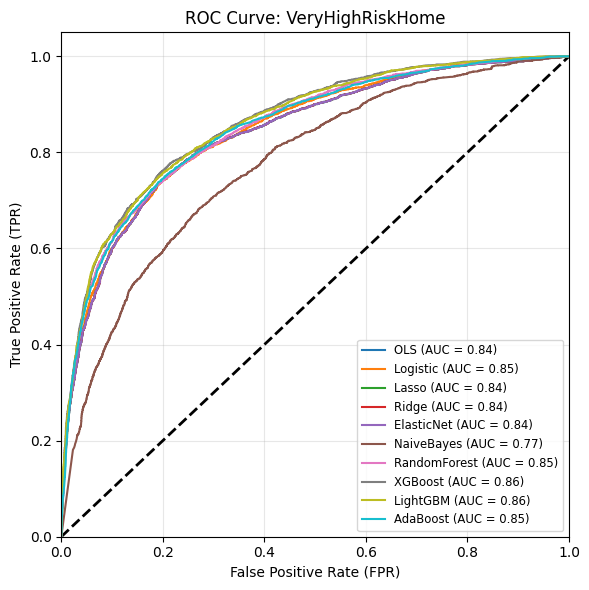

In [8]:
# Target: VeryHighRiskHome
y_veryhigh = data_complete['VeryHighRiskHome']

# Split data into train/test (80/20) with matching indices
X_train, X_test, y_veryhigh_train, y_veryhigh_test = train_test_split(
    X, y_veryhigh, test_size=0.2, random_state=42, stratify=y_veryhigh
)

# Scale the split data
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# Preserve test splits for ROC plotting
X_test_veryhigh = X_test
X_test_veryhigh_scaled = X_test_scaled

print(f'Train/Test split for VeryHighRiskHome:')
print(f'  Training: {len(y_veryhigh_train)} samples')
print(f'  Test: {len(y_veryhigh_test)} samples')
print(f'  Class distribution (train): {dict(y_veryhigh_train.value_counts())}')


print(f"Target variable: VeryHighRiskHome")
print(f"Class distribution:\n{y_veryhigh.value_counts()}")

# Get model configurations
models_scaled, models_unscaled = get_models_and_params()

# Train models that need scaling
results_veryhigh = {}

print("\n" + "="*60)
print("Training models with SCALED features")
print("="*60)

for model_name, model_config in models_scaled.items():
    model, train_metrics, test_metrics = train_and_evaluate_model(model_name, model_config, X_train_scaled, y_veryhigh_train, X_test_scaled, y_veryhigh_test, use_scaled=True)
    results_veryhigh[model_name] = {'model': model, 'train': train_metrics, 'test': test_metrics, 'use_scaled': True}

print("\n" + "="*60)
print("Training models with UNSCALED features (tree-based)")
print("="*60)

# Train tree-based models without scaling
for model_name, model_config in models_unscaled.items():
    model, train_metrics, test_metrics = train_and_evaluate_model(model_name, model_config, X_train, y_veryhigh_train, X_test, y_veryhigh_test, use_scaled=False)
    results_veryhigh[model_name] = {'model': model, 'train': train_metrics, 'test': test_metrics, 'use_scaled': False}

# Create comparison table
table_veryhigh = create_comparison_table(results_veryhigh, "VeryHighRiskHome - Outcome Model Comparison")

# ROC curve with all models for this target
plot_roc_for_target("VeryHighRiskHome", results_veryhigh, y_veryhigh_test, X_test_veryhigh_scaled, X_test_veryhigh)

In [9]:
# Export to LaTeX
latex_veryhigh = table_veryhigh.to_latex(
    index=False,
    caption="VeryHighRiskHome - Robustness Analysis: 10 ML Models",
    label="tab:robustness_veryhigh"
)

with open('tables/veryhigh_robustness_table.tex', 'w') as f:
    f.write(latex_veryhigh)

## 7. Treatment/Propensity Model Analysis

### Predicting water_treatment with 10 different models

Train/Test split for water_treatment:
  Training: 44408 samples
  Test: 11102 samples
  Class distribution (train): {0: np.int64(35541), 1: np.int64(8867)}
Target variable: water_treatment
Class distribution:
water_treatment
0    44426
1    11084
Name: count, dtype: int64

Training models with SCALED features

Training OLS...

Training Logistic...
  Best params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}

Training Lasso...
  Best params: {'alpha': 0.0001}

Training Ridge...
  Best params: {'alpha': 10}

Training ElasticNet...
  Best params: {'l1_ratio': 0.1, 'alpha': 0.001}

Training NaiveBayes...
  Best params: {'var_smoothing': 1e-09}

Training models with UNSCALED features (tree-based)

Training RandomForest...
  Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}

Training XGBoost...
  Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Training LightGBM...
  Bes

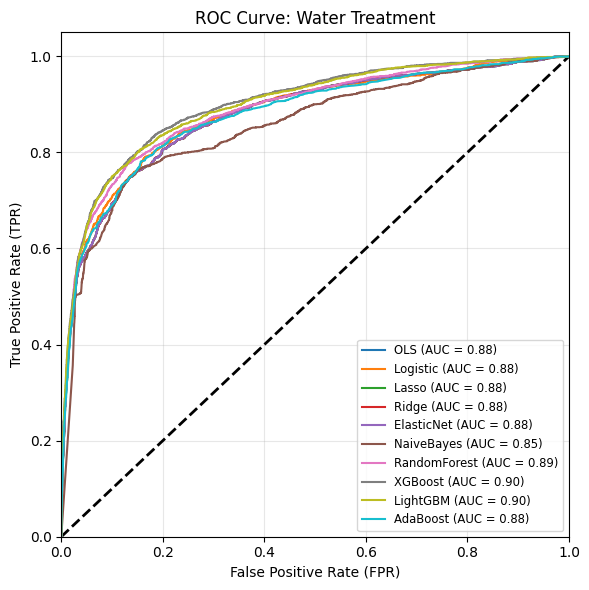

In [10]:
# Target: water_treatment (propensity model)
y_treatment = data_complete['water_treatment']

# Split data into train/test (80/20) with matching indices
X_train, X_test, y_treatment_train, y_treatment_test = train_test_split(
    X, y_treatment, test_size=0.2, random_state=42, stratify=y_treatment
)

# Scale the split data
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# Preserve test splits for ROC plotting
X_test_treatment = X_test
X_test_treatment_scaled = X_test_scaled

print(f'Train/Test split for water_treatment:')
print(f'  Training: {len(y_treatment_train)} samples')
print(f'  Test: {len(y_treatment_test)} samples')
print(f'  Class distribution (train): {dict(y_treatment_train.value_counts())}')


print(f"Target variable: water_treatment")
print(f"Class distribution:\n{y_treatment.value_counts()}")

# Get model configurations
models_scaled, models_unscaled = get_models_and_params()

# Train models that need scaling
results_treatment = {}

print("\n" + "="*60)
print("Training models with SCALED features")
print("="*60)

for model_name, model_config in models_scaled.items():
    model, train_metrics, test_metrics = train_and_evaluate_model(model_name, model_config, X_train_scaled, y_treatment_train, X_test_scaled, y_treatment_test, use_scaled=True)
    results_treatment[model_name] = {'model': model, 'train': train_metrics, 'test': test_metrics, 'use_scaled': True}

print("\n" + "="*60)
print("Training models with UNSCALED features (tree-based)")
print("="*60)

# Train tree-based models without scaling
for model_name, model_config in models_unscaled.items():
    model, train_metrics, test_metrics = train_and_evaluate_model(model_name, model_config, X_train, y_treatment_train, X_test, y_treatment_test, use_scaled=False)
    results_treatment[model_name] = {'model': model, 'train': train_metrics, 'test': test_metrics, 'use_scaled': False}

# Create comparison table
table_treatment = create_comparison_table(results_treatment, "Treatment (water_treatment) - Propensity Model Comparison")

# ROC curve with all models for this target
plot_roc_for_target("Water Treatment", results_treatment, y_treatment_test, X_test_treatment_scaled, X_test_treatment)

In [11]:
# Export to LaTeX
latex_treatment = table_treatment.to_latex(
    index=False,
    caption="Treatment (water_treatment) - Robustness Analysis: 10 ML Models",
    label="tab:robustness_treatment"
)

with open('tables/treatment_robustness_table.tex', 'w') as f:
    f.write(latex_treatment)

## 8. Summary and Comparison

In [12]:
print("\n" + "="*100)
print("ROBUSTNESS ANALYSIS COMPLETE".center(100))
print("="*100)

print("\n📊 Summary of Results:\n")

# Best models for each target
# FIX: Added ['test'] to access the nested dictionary before accessing ['F1']
print("Best performing models (by Test F1 score):\n")

best_somerisk = max(results_somerisk.items(), key=lambda x: x[1]['test']['F1'])
print(f"  SomeRiskHome: {best_somerisk[0]} (F1={best_somerisk[1]['test']['F1']:.4f})")

best_veryhigh = max(results_veryhigh.items(), key=lambda x: x[1]['test']['F1'])
print(f"  VeryHighRiskHome: {best_veryhigh[0]} (F1={best_veryhigh[1]['test']['F1']:.4f})")

best_treatment = max(results_treatment.items(), key=lambda x: x[1]['test']['F1'])
print(f"  Treatment (water_treatment): {best_treatment[0]} (F1={best_treatment[1]['test']['F1']:.4f})")

print("\n" + "="*100)
print("\n✅ All robustness checks completed successfully!")
print("   - 10 models tested for SomeRiskHome (outcome model)")
print("   - 10 models tested for VeryHighRiskHome (outcome model)")
print("   - 10 models tested for water_treatment (propensity model)")
print("   - Total: 30 models trained and evaluated")
print("   - LaTeX tables generated for all comparisons")


                                    ROBUSTNESS ANALYSIS COMPLETE                                    

📊 Summary of Results:

Best performing models (by Test F1 score):

  SomeRiskHome: XGBoost (F1=0.9005)
  VeryHighRiskHome: XGBoost (F1=0.6763)
  Treatment (water_treatment): RandomForest (F1=0.6799)


✅ All robustness checks completed successfully!
   - 10 models tested for SomeRiskHome (outcome model)
   - 10 models tested for VeryHighRiskHome (outcome model)
   - 10 models tested for water_treatment (propensity model)
   - Total: 30 models trained and evaluated
   - LaTeX tables generated for all comparisons


## 9. Cross-Model Comparison

### Compare performance across all three targets

In [13]:
# Create a combined comparison showing each model's performance across all targets
comparison_data = []

for model_name in results_somerisk.keys():
    # Helper to safely get metric, handling nested structure
    # We default to 'test' set as that is standard for comparison
    sr_test = results_somerisk[model_name]['test']
    vh_test = results_veryhigh[model_name]['test']
    tr_test = results_treatment[model_name]['test']

    comparison_data.append({
        'Model': model_name,
        # SomeRisk Metrics
        'SomeRisk_F1': f"{sr_test['F1']:.4f}",
        'SomeRisk_AUC': f"{sr_test['AUC']:.4f}" if not np.isnan(sr_test['AUC']) else 'N/A',
        
        # VeryHighRisk Metrics
        'VeryHigh_F1': f"{vh_test['F1']:.4f}",
        'VeryHigh_AUC': f"{vh_test['AUC']:.4f}" if not np.isnan(vh_test['AUC']) else 'N/A',
        
        # Treatment Metrics
        'Treatment_F1': f"{tr_test['F1']:.4f}",
        'Treatment_AUC': f"{tr_test['AUC']:.4f}" if not np.isnan(tr_test['AUC']) else 'N/A'
    })

comparison_table = pd.DataFrame(comparison_data)

print("\n" + "="*120)
print("Cross-Model Performance Comparison (Test Set F1 and AUC scores)".center(120))
print("="*120)
print(comparison_table.to_string(index=False))
print("="*120)

# Export to LaTeX
latex_comparison = comparison_table.to_latex(
    index=False,
    caption="Cross-Model Performance Comparison: All Targets (Test Set)",
    label="tab:robustness_comparison"
)

with open('tables/cross_model_comparison_table.tex', 'w') as f:
    f.write(latex_comparison)


                            Cross-Model Performance Comparison (Test Set F1 and AUC scores)                             
       Model SomeRisk_F1 SomeRisk_AUC VeryHigh_F1 VeryHigh_AUC Treatment_F1 Treatment_AUC
         OLS      0.8923       0.8712      0.6602       0.8414       0.6545        0.8781
    Logistic      0.8950       0.8797      0.6628       0.8451       0.6660        0.8820
       Lasso      0.8921       0.8713      0.6595       0.8414       0.6540        0.8781
       Ridge      0.8923       0.8713      0.6596       0.8414       0.6545        0.8781
  ElasticNet      0.8921       0.8713      0.6597       0.8414       0.6532        0.8781
  NaiveBayes      0.7427       0.8058      0.5988       0.7745       0.5207        0.8548
RandomForest      0.8965       0.8849      0.6671       0.8508       0.6799        0.8889
     XGBoost      0.9005       0.8932      0.6763       0.8613       0.6760        0.9004
    LightGBM      0.8972       0.8917      0.6745       0.8596      